
**Name:** Aparna Iyer<br>
**PRN:** 22070126017<br>
**Batch:** 2022-2026<br>
**Branch:** AI-ML A1<br>

##**Experiment 7**

###**1. Title**:
Pneumonia Classification using Chest X-rays based on Convolutional Neural Nets with Hyper-parameter tuning for CNN


### **2. Objectives:**

A. Study the Pneumonia Dataset: Understand the structure, classes, and features of the dataset containing chest X-ray images for pneumonia detection.

B. Study CNN in Detail: Explore Convolutional Neural Networks (CNN), focusing on architecture, layers, and the impact of various hyperparameters.

C. Implement in Google Colab: Develop and train a CNN model using Google Colab, applying hyper-parameter tuning to optimize model performance.

###**3. Theory:**

Convolutional Neural Networks (CNNs) are a class of deep learning models primarily used for image classification tasks. They utilize convolutional layers to automatically extract features from images, reducing the need for manual feature engineering.

The architecture of a CNN typically consists of:

A. Convolutional Layers: These apply filters to input images to detect features such as edges, textures, and patterns.

B. Pooling Layers: These reduce the dimensionality of the feature maps, retaining important information while minimizing computational load.

C. Fully Connected Layers: These perform the final classification based on the features extracted by the convolutional layers.


Hyperparameter tuning involves adjusting the parameters of the model that are not learned during training, such as learning rate, batch size, number of epochs, and architecture settings (e.g., number of layers, number of filters).

Proper tuning is crucial as it can significantly improve the model's accuracy and generalization capabilities.

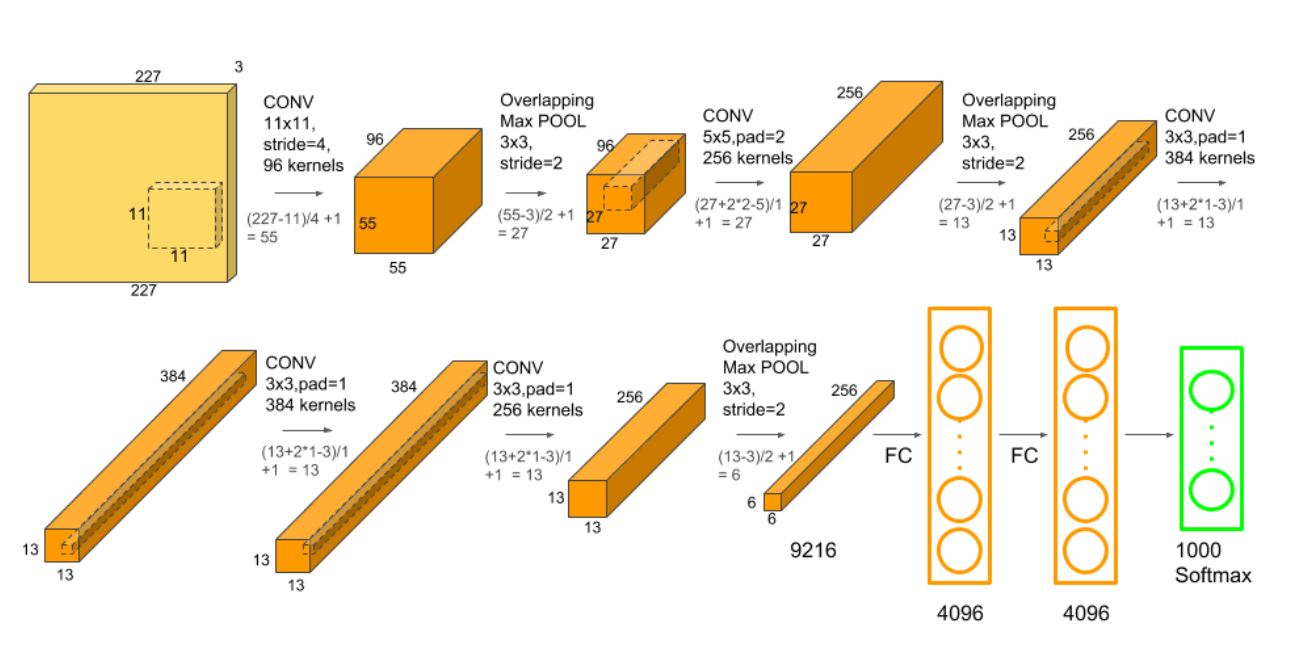

In [ ]:
# Install Kaggle API
!pip install kaggle
# Make a directory for Kaggle and upload the kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Set permissions for the Kaggle API token
!chmod 600 ~/.kaggle/kaggle.json
# Download the Pneumonia dataset from Kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# Unzip the dataset
!unzip chest-xray-pneumonia.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
##Hyperparameter tuning
!pip install keras-tuner
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
  train_dir,
  target_size=(150, 150),
  batch_size=32,
  class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
val_dir,
target_size=(150, 150),
batch_size=32,
class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(150, 150),
batch_size=32,
class_mode='binary'
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/129.1 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.7 MB/s eta 0:00:00
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
!pip install keras-tuner
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
def build_model(hp):
  model = Sequential()
  # Convolutional layers
  model.add(Conv2D(
    filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
    kernel_size=(3, 3),
    activation='relu',
    input_shape=(150, 150, 3)
  ))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(
    filters=hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
    kernel_size=(3, 3),
    activation='relu'
  ))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(
    filters=hp.Int('conv_3_filters', min_value=128, max_value=512, step=128),
    kernel_size=(3, 3),
    activation='relu'
  ))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(
    units=hp.Int('dense_units', min_value=128, max_value=512, step=64),
    activation='relu'
  ))

  model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
  model.add(Dense(1, activation='sigmoid'))
  #learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(
    optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
    #optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

  return model


In [ ]:
tuner = kt.RandomSearch(
  build_model,
  objective='val_accuracy',
  max_trials=10, # Number of different hyperparameter combinations to try
  executions_per_trial=3, # Number of models to build and evaluate per trial
  directory='my_dir',
  project_name='pneumonia_cnn',
  seed = 2
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Search for the best hyperparameters
tuner.search(
  train_generator,
  epochs=3,
  validation_data=val_generator,
  callbacks=[stop_early]
)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: {best_hyperparameters.values}")

Trial 10 Complete [00h 12m 11s]
val_accuracy: 0.8541666666666666

Best val_accuracy So Far: 0.875
Total elapsed time: 02h 05m 06s
Best Hyperparameters: {'conv_1_filters': 128, 'conv_2_filters': 64, 'conv_3_filters': 128, 'dense_units': 384, 'dropout_rate': 0.4, 'optimizer': 'adam'}


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
test_loss, test_acc = best_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc}')
best_model.save('best_pneumonia_cnn_model.h5')

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 441ms/step - accuracy: 0.6666 - loss: 0.6589


Test Accuracy: 0.6538461446762085


### **4. Conclusion**
The code runs models with multiple hyperpaprameters for 3 epochs, 4 times with the goal of improving validation accuracy and saving the model with the improved accuracy.

It finally gives the model with the best results for all the different combinations of hyperparameters.

The validation accuracy is 85.41% whereas the testing accuracy is 65.38%.

This discrepancy can be due to overfitting or misrepresentation of the data overall between the testing data and the training data.

Regardless of the final performance, we now know the ideal hyperpaprameters for the model for this use case as these returned the best validation accuracy.

By incorporating hyper-parameter tuning, we enhance the model's performance, making it robust for practical applications.

The results from this experiment can potentially assist in early detection and diagnosis of pneumonia, contributing to better patient outcomes.

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc

In [ ]:
!pip install pypandoc

In [ ]:
!apt-get update
!apt-get install -y pandoc

In [ ]:
!apt-get install pandoc

In [ ]:
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic


In [ ]:
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/DL_Lab_Experiment_7_AparnaIyer.ipynb"